# Object Recognition and Explanation

**Model Goal**: to recognize, after a training phase with a dataset of images containing numbers, the numbers that are depicted. In a second phase, it must be able to recognize if the image does not contain numbers and/or objects, it must be able to understand the text depicted inside the image. 
Last phase: creation of a prompt to communicate with the model, to be able to provide context to the images, and to be able to ask questions.

## Number Identification using CNN

I'm referring to this online notebook for the number identification part: 

https://kaggle.com/code/arunrk7/digit-recognition-using-cnn-99-accuracy/notebook

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-09-30 17:14:29.954614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 17:14:30.095331: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 17:14:30.124730: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 17:14:30.318084: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 17:14:33.237782: W tensorflow/compiler/tf2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

# setting theme of the data visualizer
sns.set(style="dark",context="notebook",palette="muted")

### Preparing Dataset

Data is provided by **MNIST Handwritten Digit Recognition competition** (kaggle.com/competitions/digit-recognizer).

- ```train.csv``` **contains both the images of the numbers** (in the form of pixels) and **the labels corresponding to the numbers (from 0 to 9)**.
- ```test.csv``` **contains only the images of the numbers**, without the labels (which must be provided by our model).

In [ ]:
train = pd.read_csv("/../Number Recognition/train.csv")
test = pd.read_csv("../Number Recognition/test.csv")

```Y_train``` will contain the number labels: this "label" column represents the numeric values ​​(0-9) associated with each image in the training dataset.

We remove the label column from the training dataset, creating ```X_train``` which **will contain only the image data in pixel form (without the labels)**. Each image is represented by a row in the dataset, and each column (except "label") represents a pixel.

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

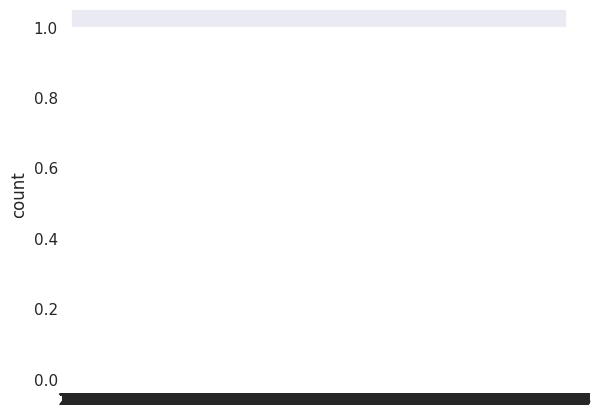

In [5]:
Y_train = train['label']

# dropping Label Column
X_train = train.drop(labels=['label'],axis=1)

# free up some space
del train

graph = sns.countplot(Y_train)
 
Y_train.value_counts()

```sns.countplot(Y_train)``` creates a bar chart showing the distribution of number labels in the training dataset. In other words, it shows how many images there are for each number (from 0 to 9).

So: 

- ```Y_train``` contains labels corresponding to actual numbers in the images. Each value in Y_train represents the number (0 to 9) depicted in an image.

- ```X_train``` contains only the image data (without labels), where each row represents an image and each column represents the value of a single pixel. The images in the dataset are in flattened format (a single vector of pixels) and no longer contain labels after running the drop() command.

If ```Y_train[0]``` == 3, then the first image of X_train represents the number "3".
```X_train[0]``` represents the pixel values ​​that form the image of the number 3.

### Normalization and Reshaping

The pixel value ranges from 0 to 255 which specify gradient of gray. The CNN will converge more faster on values 0 to 1 than 0 to 255. So **we divide every value by 255 to scale the data from [0..255] to [0..1]**. It helps the model to better learning of features by decreasing computational complexities if we have data that scales bigger.

In [6]:
X_train = X_train/255
test = test/255

The array of pixel values are **reshaped into a (28, 28, 1) matrix**. We are feeding the CNN model with input_shape of 28 x 28 x 1 matrix.

In [7]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

The ```reshape()``` function is used to **reorganize the image pixel array from a flat (1D vector) format into a more natural format** for processing by CNNs. 

- **Before reshaping**: Images in the dataset are represented as 1D vectors of pixels. For a dataset like MNIST, which has **28x28 pixel images**, **each image is initially flattened into an array of 784 pixel values ​​(i.e. 28 * 28 = 784)**. In other words, **each image is a row with 784 columns representing individual pixel values**.

- **After reshaping**: With ```X_train.values.reshape(-1, 28, 28, 1)```, **we are rearranging each 784 pixel vector into a 28x28 matrix with an additional channel**, represented by 1 at the end. **This creates an array of shape (28, 28, 1), which corresponds to the structure of the original image: 28x28 is the resolution of the image, and 1 indicates that the image has only one channel (in this case, it is a grayscale)**.

In [8]:
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=10)

Then, we convert labels into a format called **"one-hot encoding"**: **it transforms the labels (which are integers, such as 0, 1, 2, ... 9 in the case of digit recognition) into binary vectors called one-hot vectors**. **Each numeric label is represented as a vector of length equal to the number of classes** (in this case 10, for the digits from 0 to 9).

For example: if the label is 7, the one-hot vector will be: ```[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]```

Many deep learning models, including those based on Keras or TensorFlow, expect labels to be in one-hot format during the training phase.

Example of use in the context of digit recognition (MNIST): suppose our label dataset Y_train contains the digits 0 to 9. Without one-hot encoding, Y_train would have values ​​like:

```Y_train = [0, 7, 1, 4, 9, ...]```

After applying to_categorical(), each label will be converted into a one-hot vector:

```
Y_train = [
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # represents "0"
  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # represents "7"
  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],  # represents "1"
  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],  # represents "4"
  ...
]
```

### Train and Validation Data Split

We are now **segmenting the input data for training into two exclusive data namely, Train and Validation datasets**. **Train data is used to train the model, whereas the validation data is used for cross verification of the model's accuracy and how well the model is generalized for the data other than training data**.

Validation accuracy and loss will tell us the performance of the model for new data and it will show if there is overfitting or underfitting situation while model training.

In [9]:
# splitting Train and test set
random_seed=2

X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=0.1,
                                                random_state = random_seed)

- ```X_train``` and ```Y_train```: These contain the **images (data) and labels for training the model respectively**.
- ```X_val``` and ```Y_val```: These contain **the images and labels for validation**. During training, the model will be evaluated on this set to see how it performs on data it has never seen before, giving an indication of how it might generalize to new data.

```test_size=0.1``` means that **10% of the original data will be used as the validation set**, **while the remaining 90% will be used for training**.

The random seed makes sure that the dataset will be splitted in the same way at every code execution.

### Model 

CNN uses convolutional layers to extract image features and reduce dimensionality through pooling. The fully connected layers finally do classification based on the extracted features, and techniques like **ReLU (nonlinear activation)** and **Dropout (overfitting prevention)** help improve the accuracy and generalization of the model.

The CNN has the following structure:

**Input → [[Conv2D → ReLU] * 2 → MaxPool2D → Dropout] * 2 → Flatten → Dense → Dropout → Output**

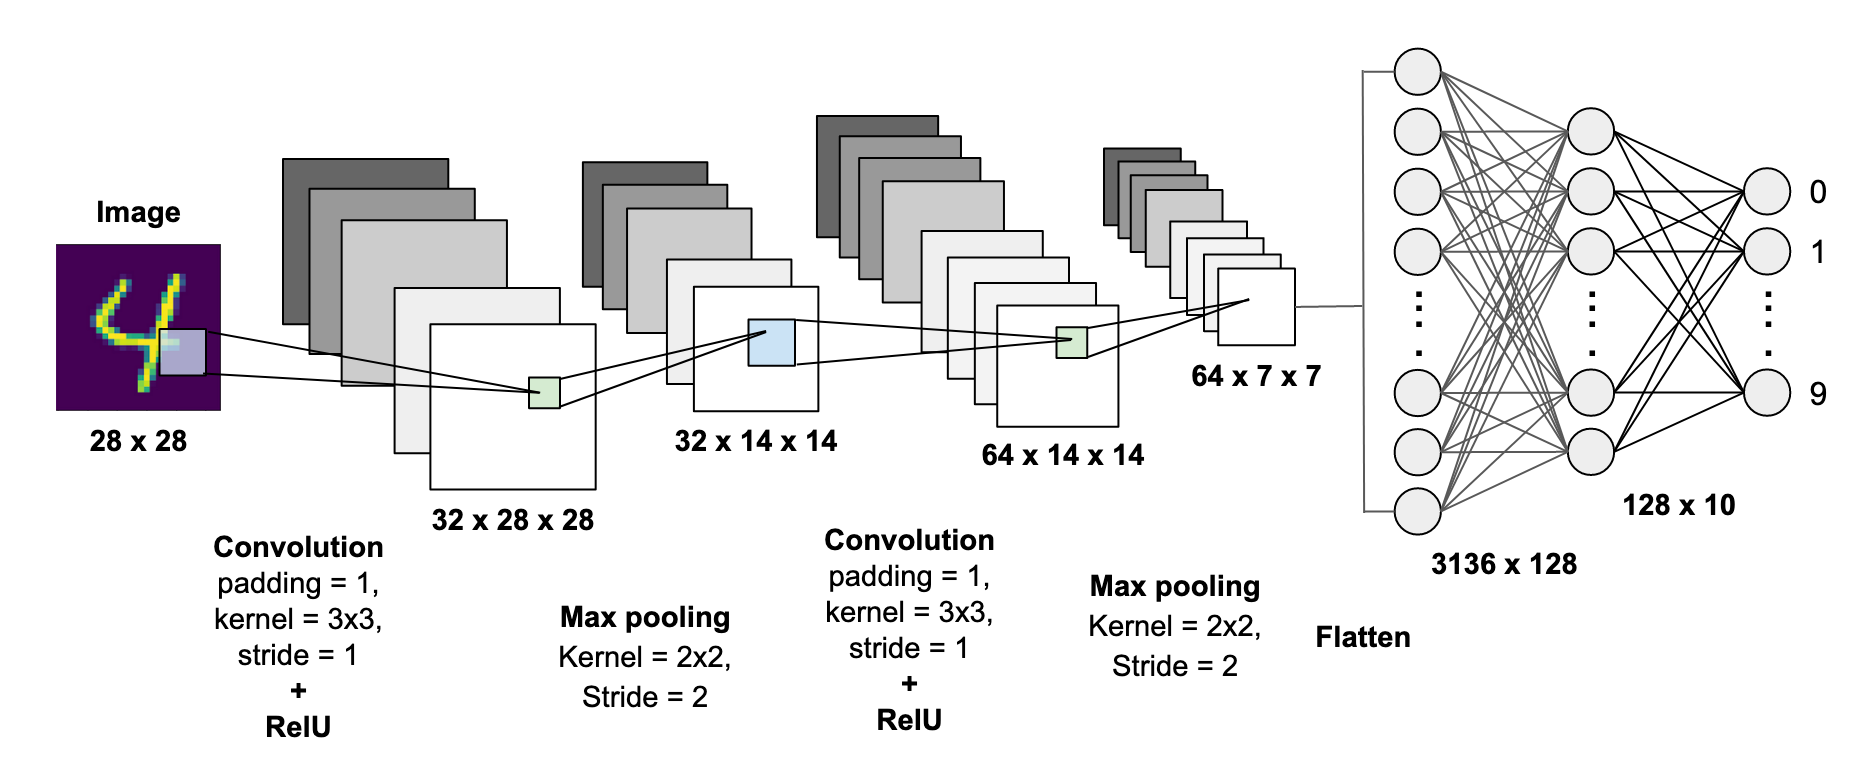

In [10]:
model = tf.keras.Sequential()

#### First Convolutional Block

1. **Conv2D**. It applies a 2D convolution with 32 filters, each of which is 5x5 in size. 
    - ```padding='Same'``` means that **the edges of the image are padded** so that the output of the convolution has the same size as the input.
    - ```activation=tf.nn.relu```: Uses **the ReLU (Rectified Linear Unit) activation function** to introduce nonlinearity.
    - ```input_shape=(28,28,1)```: Specifies the size of the input, in this case 28x28 pixel images with a single channel (grayscale images).

In [11]:
model.add(layers.Conv2D(filters=32, kernel_size=(5,5), padding='Same', 
                       activation=tf.nn.relu, input_shape = (28,28,1)))

/home/pierluigi/Documents/virtual_ambients/objectdet/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1727710253.874899     591 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-30 17:30:53.968444: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and set

2. **Second convolutional block**: another convolution with the same parameters (32 5x5 filters) and ReLU activation. It is common to stack multiple convolutional layers before reducing the dimensionality with a MaxPooling.

In [12]:
model.add(layers.Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation=tf.nn.relu))

3. **MaxPool2D**: Reduces the spatial dimension (width and height) of the output by taking the maximum value in each 2x2 window. This reduces model complexity and increases efficiency by reducing overfitting.

In [13]:
model.add(layers.MaxPool2D(pool_size=(2,2)))

4. **Dropout(0.25)**: Randomly turns off 25% of the neurons in this layer during training to prevent overfitting. Improves the generalization ability of the model.

In [14]:
model.add(layers.Dropout(0.25))

#### Second Convolutional Block

1. **Two convolutional layers with 64 filters of size 3x3 each, and ReLU activation**. Increasing the number of filters (from 32 to 64) allows learning more complex features from images.

In [15]:
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation=tf.nn.relu))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation=tf.nn.relu))

2. **Another layer of max pooling with a 2x2 window**. This further reduces the spatial dimension of the image, helping to reduce model complexity.

In [16]:
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))

3. **Reapply a 25% Dropout to prevent overfitting**.

In [17]:
model.add(layers.Dropout(0.25))

#### Flatten Layer

It flattens the output of the convolutional layers into a 1D vector, so that it can be used as input for the fully connected (Dense) layers.

In [18]:
model.add(layers.Flatten())

#### Dense layer (fully connected)

Fully connected layer with 256 neurons, with ReLU activation. Here the model learns complex relationships between features learned from previous convolutions, plus another Dropout layer for preventing overfitting. 

In [19]:
model.add(layers.Dense(256, activation=tf.nn.relu))

In [20]:
model.add(layers.Dropout(0.25))

#### Output Layer 

**Output layer with 10 neurons, one for each of the 10 classes (digits from 0 to 9** in the case of the MNIST dataset).

In [21]:
model.add(layers.Dense(10, activation=tf.nn.softmax))

#### Optimizer 

Optimizer is the crucial part in a neural network. **RMSProp (Root Mean Square Propagation) optimizer makes the model converge more effectively and faster**: it is an optimization algorithm that is used to update the weights of the model during training, based on the error gradient. It also stricts the model to coverge at global minimum therefore the accuracy of the model will be higher.

In [22]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

/home/pierluigi/Documents/virtual_ambients/objectdet/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


- **```lr=0.001``` (Learning rate)**: Sets the rate at which the weights are updated during training. A value of 0.001 is a common choice and indicates a relatively slow update, which helps the model converge stably.
- **```rho=0.9```**: This is **the exponential decay parameter of the past squared gradient**. It is used to calculate the exponential moving average of the gradient squares. Higher values ​​of rho give more emphasis to the more recent gradients.
- **```epsilon=1e-08```**: A very small value added to ensure that no division by zero occurs when calculating weight updates. This is useful for numerical stability.
- **```decay=0.0``` (Learning rate decay)**: An optional parameter that **reduces the learning rate after each model update**. In this case it is set to 0, so the learning rate remains constant.

We now compile the model:

In [23]:
model.compile(optimizer = optimizer, loss='categorical_crossentropy', 
             metrics=["accuracy"])

```categorical_crossentropy``` is the loss function used in multi-class classification problems.
Since the labels in our dataset are encoded as one-hot vectors (thanks to the to_categorical function), this loss function calculates the difference between the predicted distributions and the true labels.

In this case, we are tracking **accuracy**, which measures the percentage of correct predictions out of the total predictions. This is a standard metric for classification problems.

In [24]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc',
                                           patience=3,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00001)

The code we provide above defines a callback called **ReduceLROnPlateau**. This callback **dynamically reduces the learning rate if the model performance (in terms of validation accuracy) does not improve after a certain number of epochs**. This is very useful to avoid the model getting stuck in a local minimum during training.

- **```patience=3```: If the model performance (validation accuracy) does not improve for 3 consecutive epochs, the learning rate will be reduced**. This helps prevent overtraining or stagnation of the model.
- **```factor=0.5```**: **The learning rate will be reduced by a factor of 0.5 (i.e., halved) every time the performance stabilizes for the patience number of epochs**.
- **```min_lr=0.00001```: Set a minimum learning rate of 0.00001, below which the learning rate will not be reduced further**. This ensures that the learning rate does not become so small that training becomes ineffective.

In [25]:
epochs=30
batch_size = 112

#### Data Augmentation

**Data Augmentation** is **the process of creating more dataset for training by manipulating the given images**. In Deep learning, the availability of large dataset is very vital for the training. **Since we have limited real world training samples, we can use data augementation to create more images for training**. Data Augmentation **involves zoom, rotating, flip, crop and other image manipulations over the available datasets to create further more data for training**. Data Augmentation makes the model to classify more generally.

In [26]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # If set to True, it would calculate the average of the entire dataset and subtract it from each image. This is not done here.
        samplewise_center=False,  # If this were set to True, it would subtract the average of each individual image. This also fails.
        featurewise_std_normalization=False,  # If set to True, it would divide each image by the standard deviation of the entire dataset.
        samplewise_std_normalization=False,  # If set to True, it would divide each image by its standard deviation.
        zca_whitening=False,  # If set to True, it would apply ZCA whitening, a preprocessing technique to reduce correlations between pixels in an image.
        rotation_range=10,  # Images will be randomly rotated up to 10 degrees clockwise or counterclockwise.
        zoom_range = 0.1, # Images can be randomly zoomed up to 10%. 
        width_shift_range=0.1,  # Images can be translated horizontally up to 10% of their width.
        height_shift_range=0.1,  # Images can be translated vertically up to 10% of their height.
        horizontal_flip=False,  # If set to True, the images would be flipped horizontally. In this case, it is not done.
        vertical_flip=False)  # If set to True, the images would be flipped vertically. In this case, it is not done.


datagen.fit(X_train)

#### Model Fitting

**Model Fitting or Model Training**: **we train our model and evaluate the error parameters**. Training process typically take a lot of time when it runs in a CPU. But the training can be speeeded up with the graphics card that have CUDA support. 

In [27]:
if(tf.test.is_built_with_cuda() == True):
    print("CUDA Available.")
else: 
    print("CUDA not Available.")

CUDA Available.


In [28]:
if tf.config.list_physical_devices('GPU'):
    print("GPUs are available.")
else:
    print("No GPUs found.")


No GPUs found.


In [29]:
tf.config.set_visible_devices([], 'GPU')  # Forza la visibilità delle GPU


In [30]:
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_val, Y_val),
    verbose=2,
    steps_per_epoch=X_train.shape[0] // batch_size,
    callbacks=[learning_rate_reduction]
)


Epoch 1/30


/home/pierluigi/Documents/virtual_ambients/objectdet/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


337/337 - 241s - 716ms/step - accuracy: 0.8675 - loss: 0.4146 - val_accuracy: 0.9829 - val_loss: 0.0562 - learning_rate: 0.0010
Epoch 2/30


/home/pierluigi/Documents/virtual_ambients/objectdet/lib/python3.11/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
2024-09-30 17:34:56.828928: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


337/337 - 4s - 13ms/step - accuracy: 0.9286 - loss: 0.1979 - val_accuracy: 0.9731 - val_loss: 0.0838 - learning_rate: 0.0010
Epoch 3/30
337/337 - 184s - 546ms/step - accuracy: 0.9661 - loss: 0.1122 - val_accuracy: 0.9826 - val_loss: 0.0556 - learning_rate: 0.0010
Epoch 4/30


2024-09-30 17:38:05.249711: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


337/337 - 3s - 10ms/step - accuracy: 0.9375 - loss: 0.1420 - val_accuracy: 0.9871 - val_loss: 0.0465 - learning_rate: 0.0010
Epoch 5/30
337/337 - 151s - 448ms/step - accuracy: 0.9755 - loss: 0.0821 - val_accuracy: 0.9886 - val_loss: 0.0389 - learning_rate: 0.0010
Epoch 6/30
337/337 - 3s - 10ms/step - accuracy: 0.9821 - loss: 0.0517 - val_accuracy: 0.9879 - val_loss: 0.0429 - learning_rate: 0.0010
Epoch 7/30
337/337 - 151s - 449ms/step - accuracy: 0.9804 - loss: 0.0652 - val_accuracy: 0.9917 - val_loss: 0.0269 - learning_rate: 0.0010
Epoch 8/30


2024-09-30 17:43:14.178065: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


337/337 - 3s - 10ms/step - accuracy: 0.9911 - loss: 0.0200 - val_accuracy: 0.9912 - val_loss: 0.0314 - learning_rate: 0.0010
Epoch 9/30
337/337 - 157s - 467ms/step - accuracy: 0.9820 - loss: 0.0583 - val_accuracy: 0.9876 - val_loss: 0.0400 - learning_rate: 0.0010
Epoch 10/30
337/337 - 5s - 14ms/step - accuracy: 0.9732 - loss: 0.0661 - val_accuracy: 0.9893 - val_loss: 0.0350 - learning_rate: 0.0010
Epoch 11/30
337/337 - 172s - 510ms/step - accuracy: 0.9836 - loss: 0.0521 - val_accuracy: 0.9890 - val_loss: 0.0386 - learning_rate: 0.0010
Epoch 12/30
337/337 - 7s - 21ms/step - accuracy: 0.9911 - loss: 0.0359 - val_accuracy: 0.9852 - val_loss: 0.0594 - learning_rate: 0.0010
Epoch 13/30
337/337 - 179s - 533ms/step - accuracy: 0.9856 - loss: 0.0473 - val_accuracy: 0.9898 - val_loss: 0.0345 - learning_rate: 0.0010
Epoch 14/30
337/337 - 4s - 12ms/step - accuracy: 0.9911 - loss: 0.0210 - val_accuracy: 0.9931 - val_loss: 0.0255 - learning_rate: 0.0010
Epoch 15/30
337/337 - 170s - 505ms/step - acc

2024-09-30 17:54:52.467644: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


337/337 - 4s - 11ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9914 - val_loss: 0.0275 - learning_rate: 0.0010
Epoch 17/30
337/337 - 162s - 481ms/step - accuracy: 0.9874 - loss: 0.0411 - val_accuracy: 0.9926 - val_loss: 0.0214 - learning_rate: 0.0010
Epoch 18/30
337/337 - 4s - 11ms/step - accuracy: 0.9911 - loss: 0.0171 - val_accuracy: 0.9936 - val_loss: 0.0191 - learning_rate: 0.0010
Epoch 19/30
337/337 - 154s - 458ms/step - accuracy: 0.9879 - loss: 0.0400 - val_accuracy: 0.9924 - val_loss: 0.0271 - learning_rate: 0.0010
Epoch 20/30
337/337 - 3s - 10ms/step - accuracy: 0.9911 - loss: 0.0241 - val_accuracy: 0.9926 - val_loss: 0.0255 - learning_rate: 0.0010
Epoch 21/30
337/337 - 156s - 462ms/step - accuracy: 0.9885 - loss: 0.0383 - val_accuracy: 0.9940 - val_loss: 0.0162 - learning_rate: 0.0010
Epoch 22/30
337/337 - 3s - 10ms/step - accuracy: 1.0000 - loss: 0.0049 - val_accuracy: 0.9950 - val_loss: 0.0162 - learning_rate: 0.0010
Epoch 23/30
337/337 - 155s - 460ms/step - ac

#### Valuating the Model

We visualize the **loss and accuracy** during training and validation of your deep learning model. 

- The first subplot (```ax[0]```) plots the training loss and validation loss.
- The second subplot (```ax[1]```) plots the accuracy and validation accuracy.

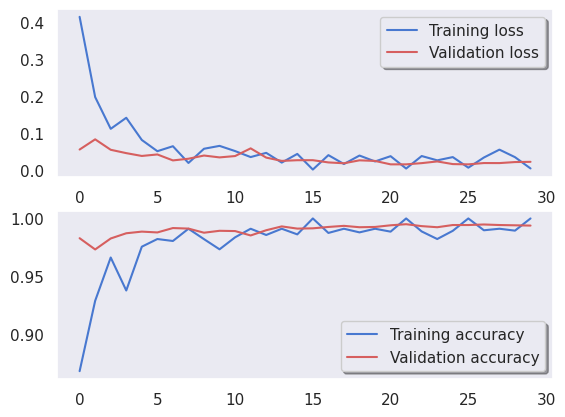

In [31]:
fig, ax = plt.subplots(2, 1)

# Plot per il training e validation loss
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss")
legend = ax[0].legend(loc='best', shadow=True)

# Plot per il training e validation accuracy
ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# Mostra i grafici
plt.show()


**Confusion Matrix** shows the performance of model in predicting every class.

132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step


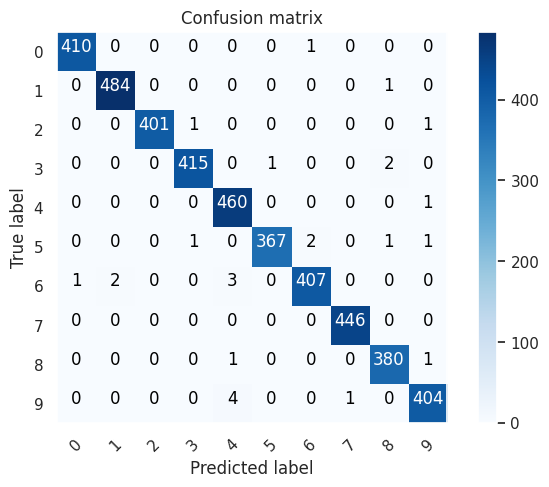

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

#### Testing the Model

We predict the test data and store it in a csv file for competition submission.

This code uses the trained CNN model to make predictions on the test data. The result of model.predict(test) will be an array with the probabilities of each class for each image in the test set.

```np.argmax``` get the index of the class with the maximum probability for each image. This means that for each image in the test set, we are choosing the class that the model thinks is most likely.

```pd.Series(range(1, 28001), name="ImageId")``` generate a series of image IDs ranging from 1 to 28000 (assuming our test set contains 28000 images). Then by concatenating this series with results, we get a DataFrame with two columns: ImageId and Label.

In [33]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)

875/875 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step


The CSV output represents the results of our model's predictions for the test set. 

- **ImageId** column: This column contains a unique identifier for each image in the test dataset. IDs range from 1 to 28000, corresponding to the total number of images in your test set. **Each row represents a single image, and the ID is used to identify that specific image**.

- **Label** column: This column contains the labels predicted by the model for each image. **The values ​​represent the digits 0 to 9, indicating which digit the model identified in the corresponding image**.

Here are some output examples:
```
ImageId 1: The image was identified as number 2.
ImageId 2: The image was identified as number 0.
ImageId 3: The image was identified as number 9.
ImageId 4: The image was identified as number 0.
ImageId 5: The image was identified as number 3.
ImageId 6: The image was identified as number 7.
```
And so on...

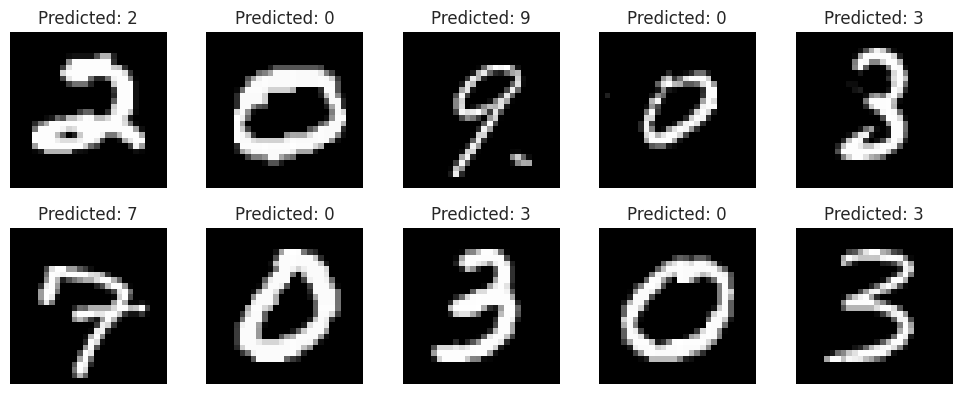

In [34]:
# Show the first 10 images of the test set with the predicted labels
def plot_images_with_labels(test_images, predictions, num_images=10):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
        plt.title(f"Predicted: {predictions[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_images_with_labels(test, results, num_images=10)

In [35]:
# Salva il modello in formato HDF5
model.save('number_recognition_model.h5')